In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

from src.rot.problem import ROT, EntropicROT
from src.rot.sinkhorn import calc_U, calc_k_formula, robust_sinkhorn_eps
from src.utils import norm_inf, calc_KL

import time

In [2]:
# Dimension
n = 100

# Regularization
tau = np.float64(1.0)

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(1.0, 50.0, (n, n)).astype(np.float64)

# Marginal vectors
a = np.random.uniform(0.1, 1.0, n).astype(np.float64)
b = np.random.uniform(0.1, 1.0, n).astype(np.float64)

a = a / a.sum()
b = b / b.sum()

# Varying $\epsilon$

Original ROT problem

In [35]:
rot = ROT(C, a, b, tau)

In [36]:
X_hat = rot.optimize_f()

f_hat = rot.calc_f(X_hat)

print('Optimal:', f_hat)

Optimal: 1.673249265519985


In [38]:
# Number of eps
neps = 20

# Epsilons
eps_arr = np.logspace(start=-1, stop=-5, num=neps).astype(np.float64)

Epsilon 0: 0.1
0 6.80058118842358
1000 1.6733556285024342
1039 1.6733556222615975


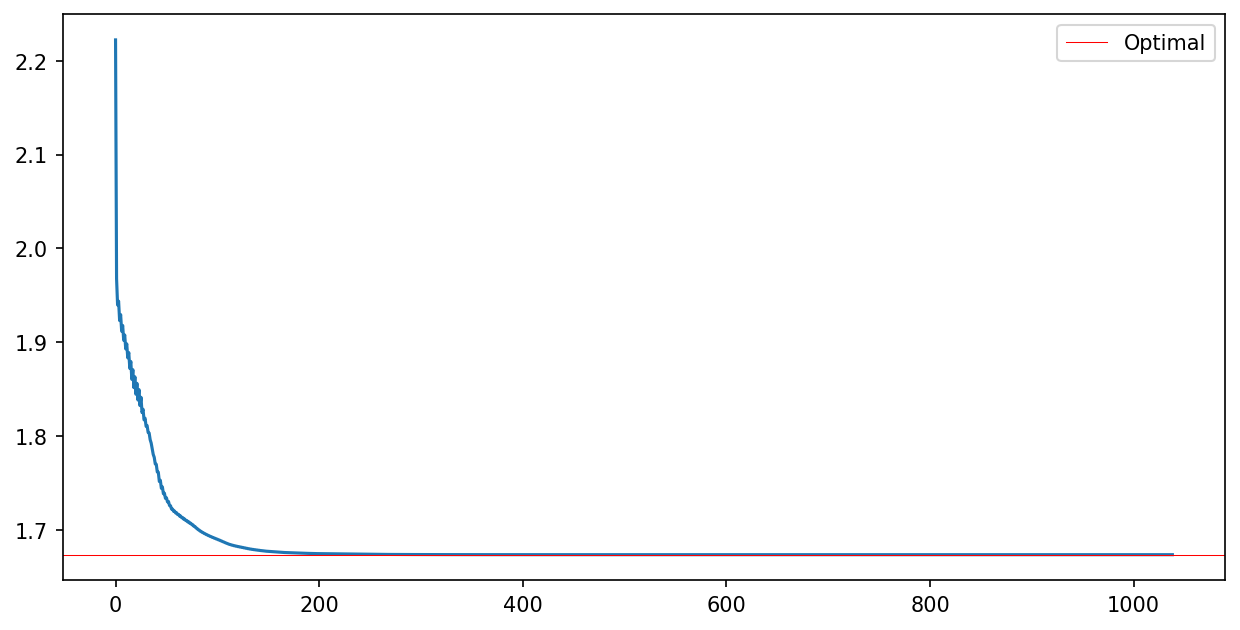

Time elapsed: 0.4130103588104248
Epsilon 1: 0.06158482110660264
0 7.630214657373651
1000 1.6732897779212603
1079 1.673289445758754


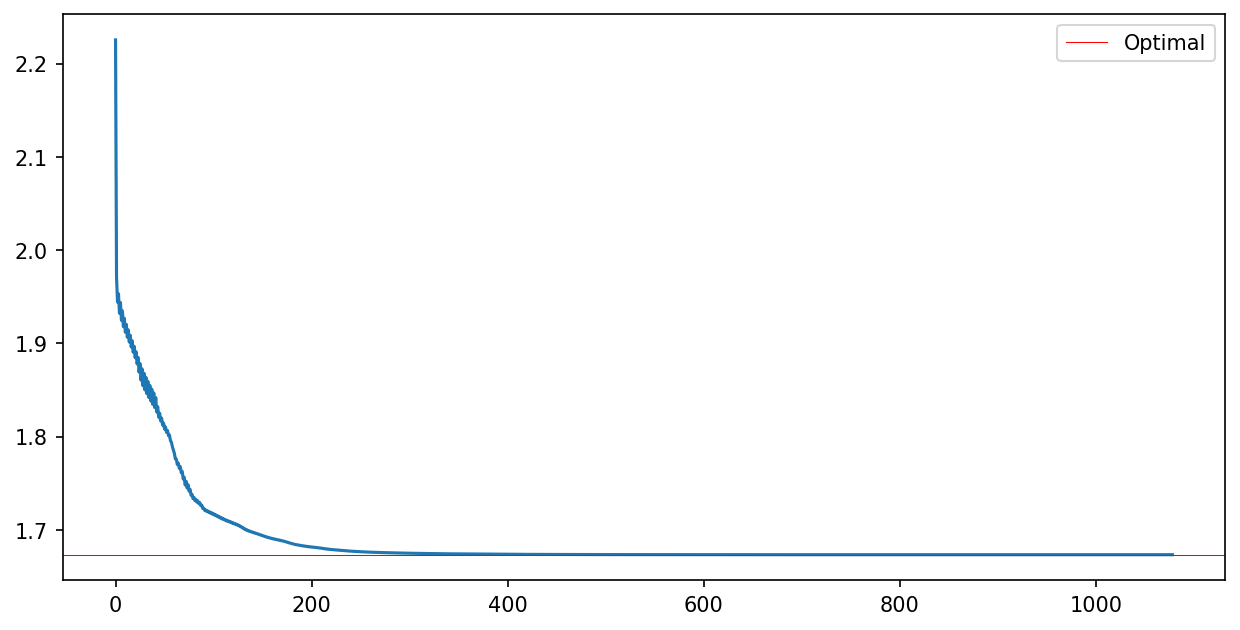

Time elapsed: 0.6293997764587402
Epsilon 2: 0.0379269019073225
0 8.367131423937318
1000 1.6732957436370295
1181 1.673271057509718


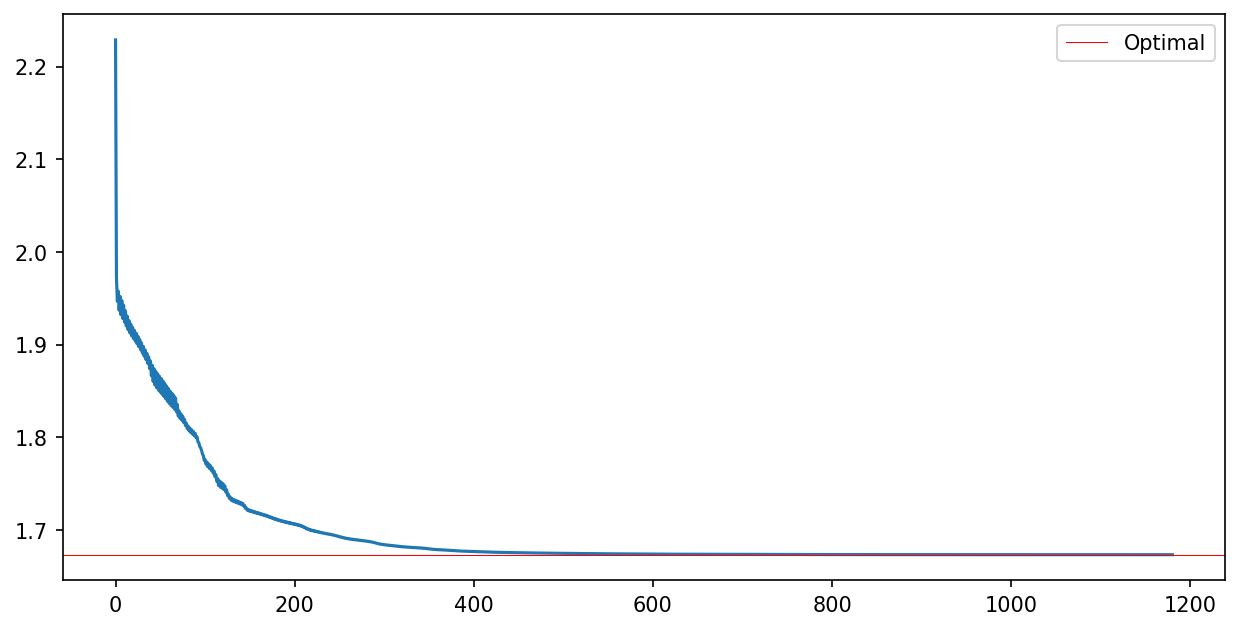

Time elapsed: 0.529707670211792
Epsilon 3: 0.023357214690901226
0 8.850476561089684
1000 1.673844212897605
1379 1.673354956713789


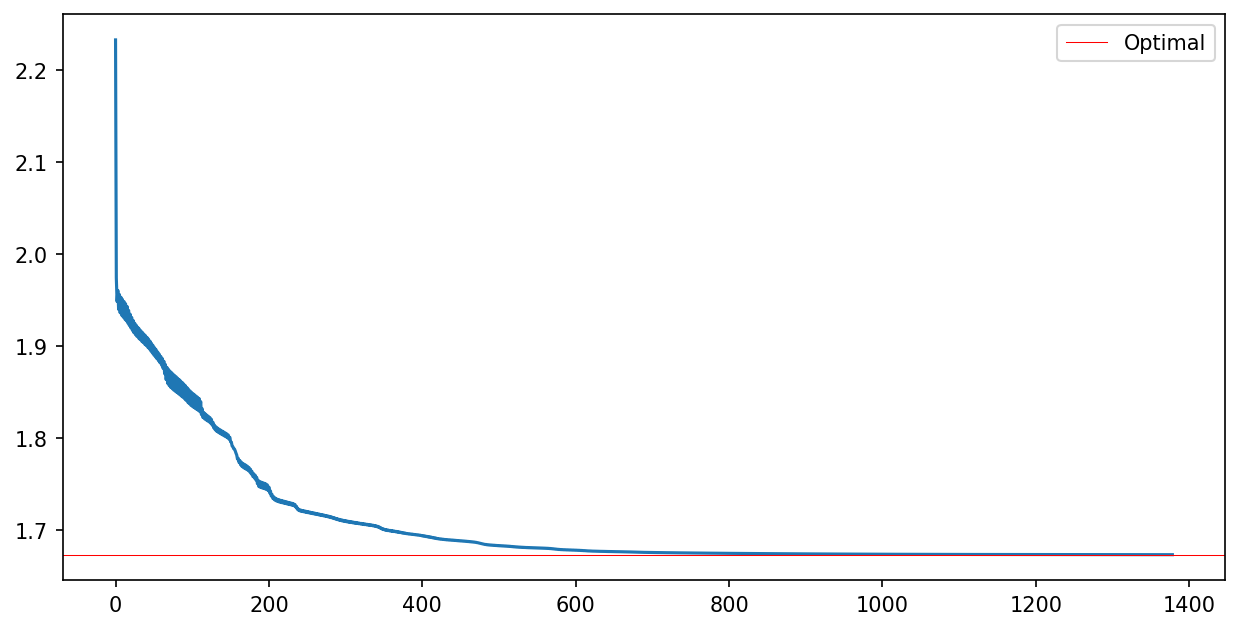

Time elapsed: 0.8321456909179688
Epsilon 4: 0.01438449888287663
0 9.042929245149427
1000 1.6774399818508274
1753 1.6736540077645679


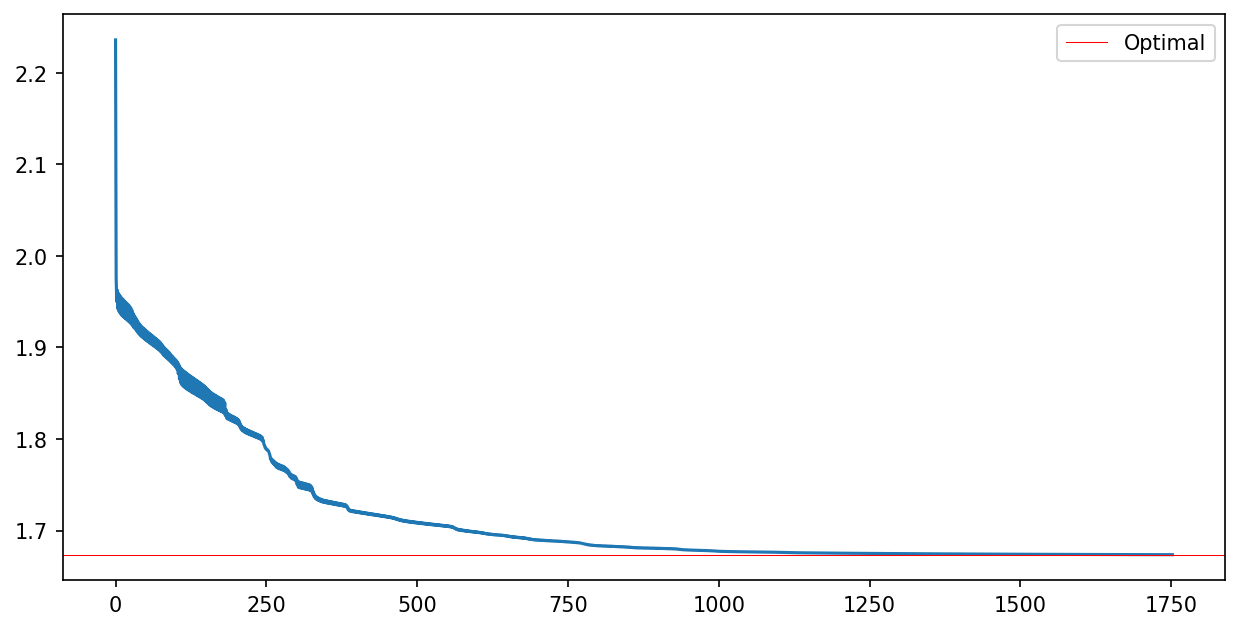

Time elapsed: 0.5825188159942627
Epsilon 5: 0.008858667904100831
0 9.124056755427603
1000 1.6965009719832447
2000 1.675138300159614
2382 1.6742395877526397


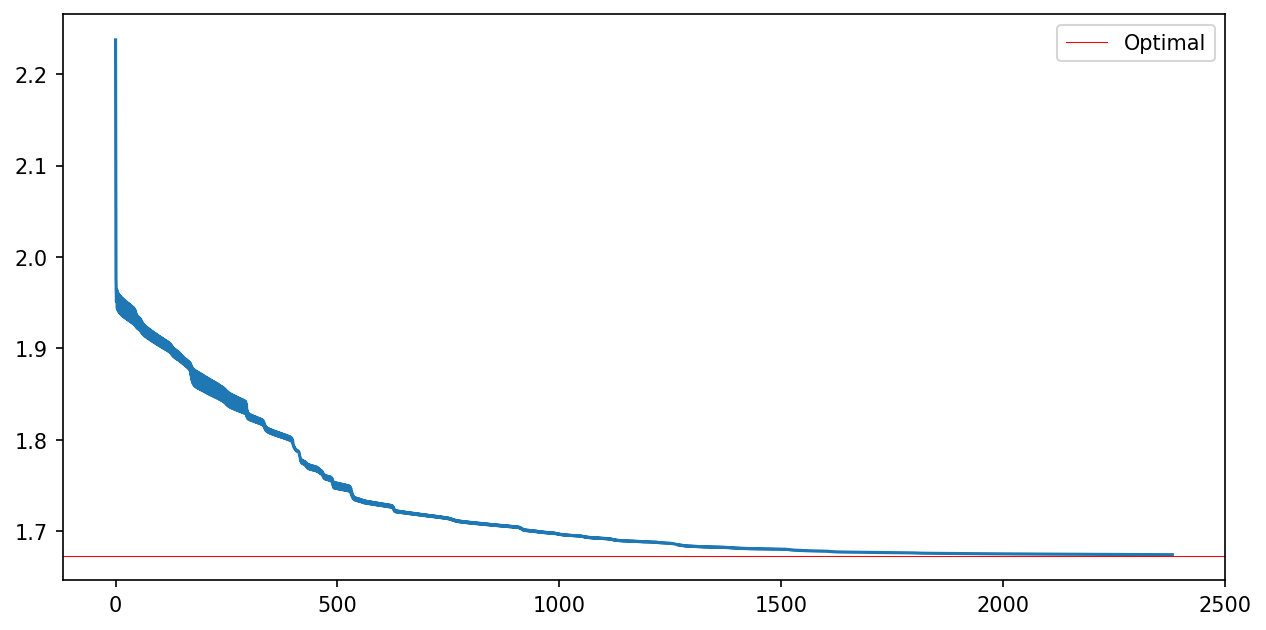

Time elapsed: 0.7062876224517822
Epsilon 6: 0.00545559478116852
0 9.235027319646171
1000 1.7267170428302494
2000 1.6872417739138976
3000 1.6756896211207755
3532 1.6746591519813487


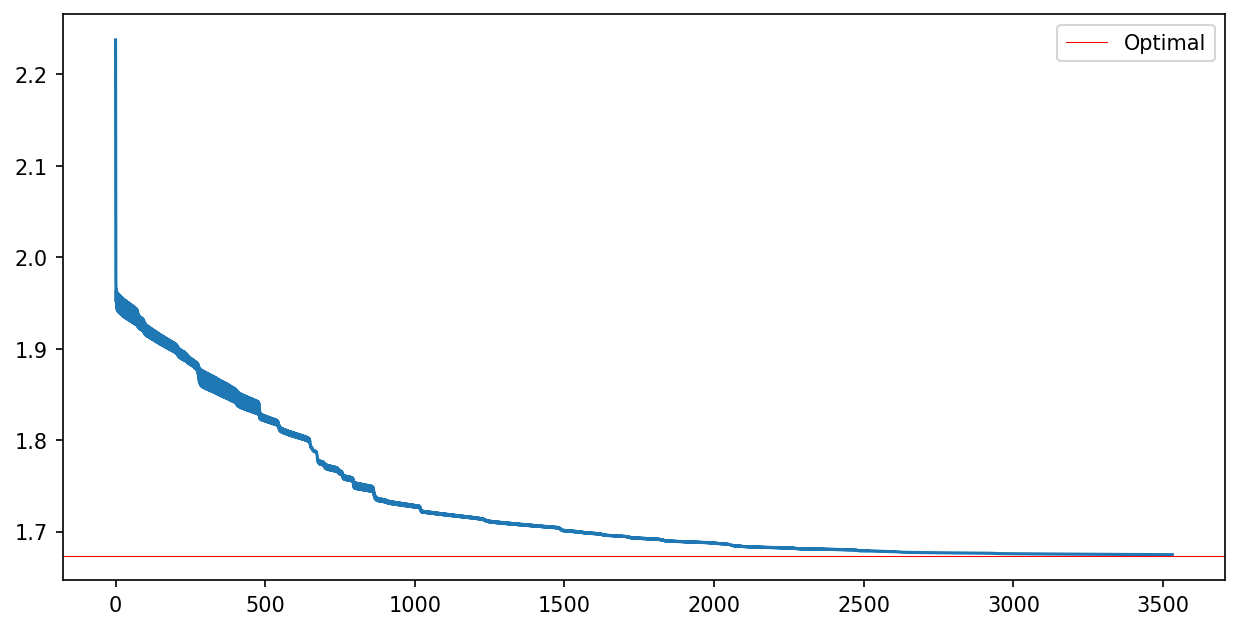

Time elapsed: 1.3308689594268799
Epsilon 7: 0.003359818286283781
0 9.4335247721674
1000 1.8058542099868775
2000 1.7129308016653806
3000 1.689433998627217
4000 1.680090070338021
5000 1.6754961182673673
5544 1.6748398073517237


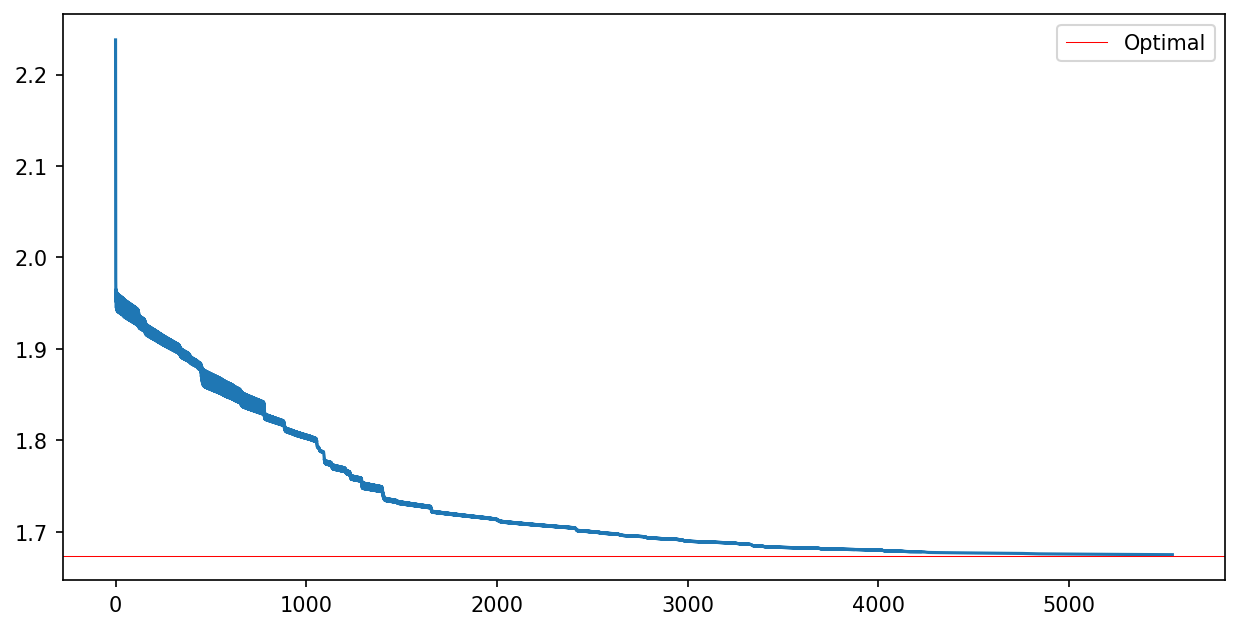

Time elapsed: 1.9310061931610107
Epsilon 8: 0.00206913808111479
0 9.780465481647845
1000 1.8604822562031422
2000 1.7593577899467738
3000 1.7167164614001875
4000 1.7002372664195333
5000 1.688763282424421
6000 1.6818828082228945
7000 1.6771315947241803
8000 1.675603449014522
9000 1.6748410903372164
9351 1.6746478772852673


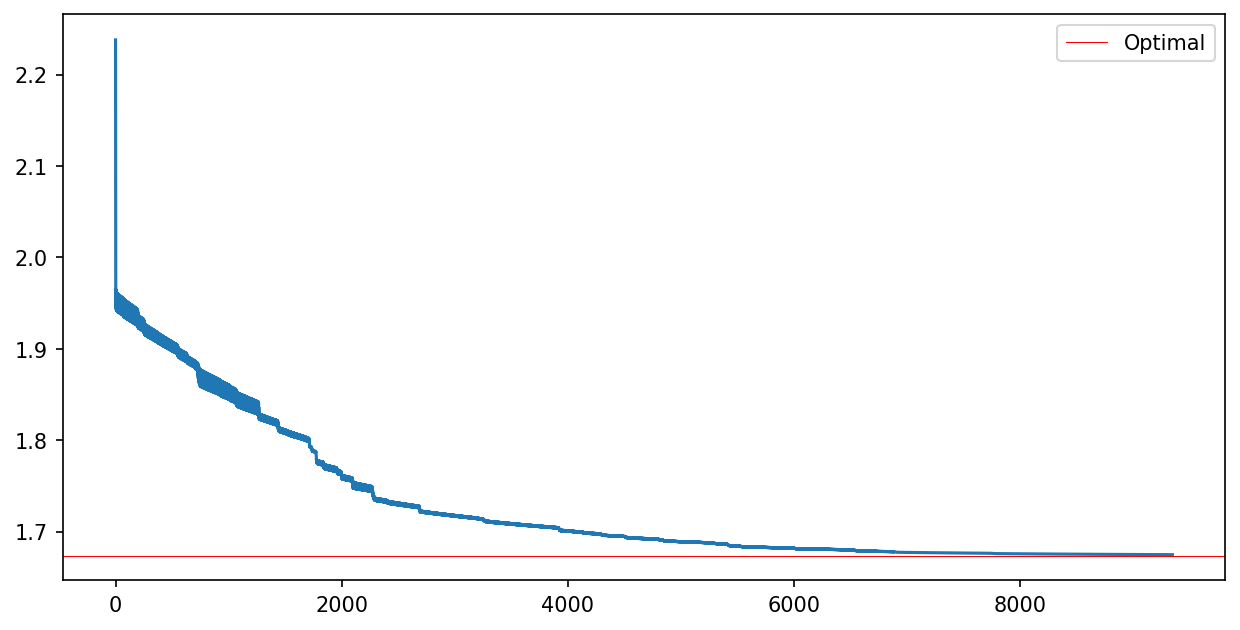

Time elapsed: 2.822200298309326
Epsilon 9: 0.0012742749857031347
0 10.31146351447009
1000 1.8957243799600367
2000 1.843509844503962
3000 1.7686825797516779
4000 1.7297688635489066
5000 1.7156169544119027
6000 1.705860150632186
7000 1.695824511529318
8000 1.6891321699076542
9000 1.6836345525884253
10000 1.6809159486646572
11000 1.67818837940924
12000 1.6765955437891102
13000 1.6755978732053778
14000 1.6750941846787146
15000 1.6747004080007828
16000 1.6743925597554725
16571 1.6742538232722042


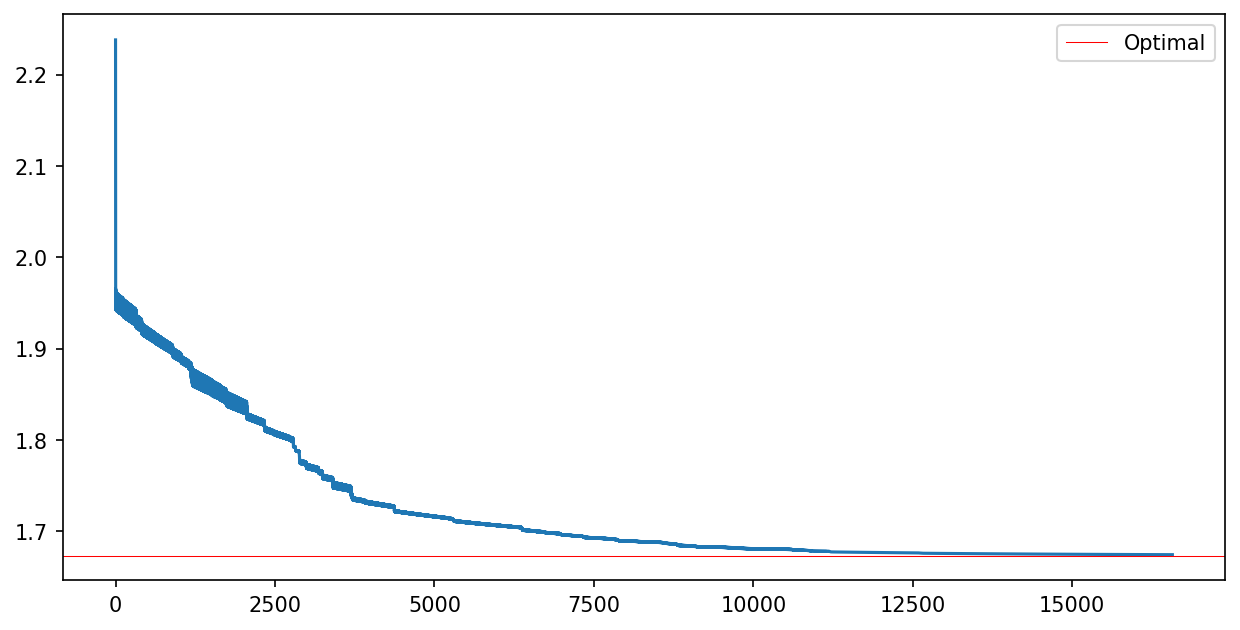

Time elapsed: 5.385802507400513
Epsilon 10: 0.0007847599703514615
0 10.895345196265453
1000 1.9171385291685497
2000 1.876311087811915
3000 1.8485172862230002
4000 1.8105115737020427
5000 1.7672043680275848
6000 1.738309961520279
7000 1.7264033271867705
8000 1.7162375177323965
9000 1.7089159052963003
10000 1.7048786093863268
11000 1.6979305705463297
12000 1.692785200809808
13000 1.6891127740744243
14000 1.6865705745795883
15000 1.68290322847321
16000 1.6811569791645145
17000 1.680199492165734
18000 1.6780889892579638
19000 1.6768374683243896
20000 1.6763577879247071
21000 1.6756363685708
22000 1.6753062347239933
23000 1.6750225433637569
24000 1.674778760747768
25000 1.6745692729332178
26000 1.674389256020895
27000 1.6742345629775086
28000 1.6740927888785888
29000 1.673950110943197
29393 1.6739142757340053


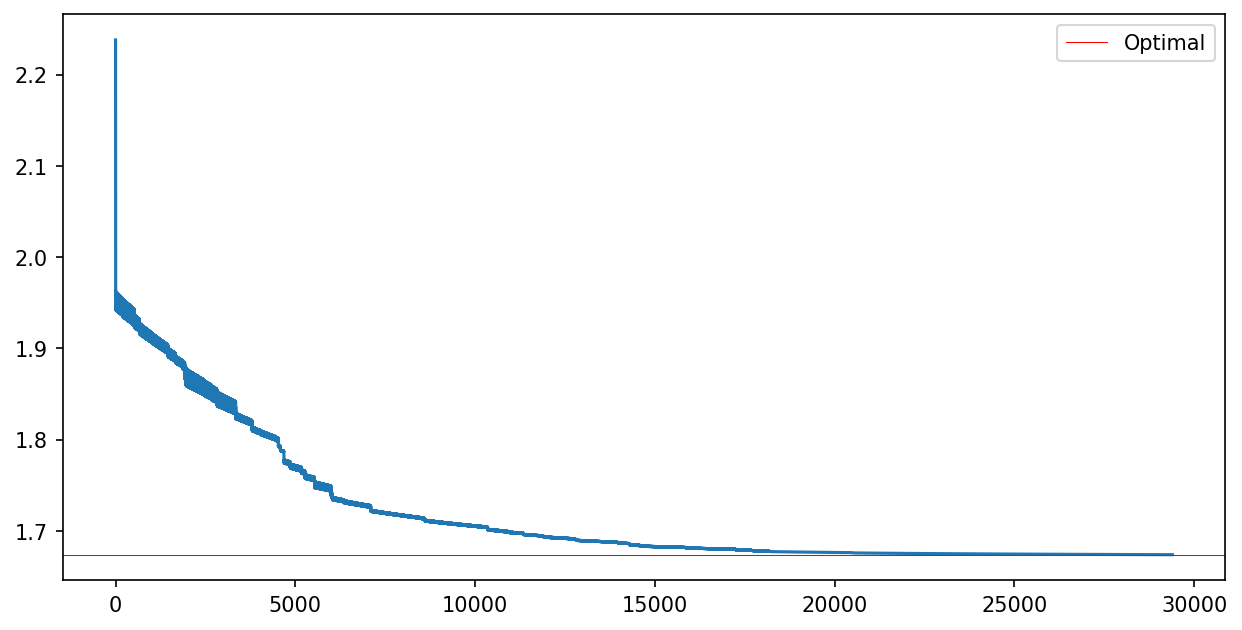

Time elapsed: 8.30795693397522
Epsilon 11: 0.0004832930238571752
0 11.248312085597476
1000 1.9335217006704961
2000 1.909994341180011
3000 1.8868612111475298
4000 1.8652196131629035
5000 1.8468900389855507
6000 1.8226708484340644
7000 1.8054030397157907
8000 1.7679853990412893
9000 1.7473531762002539
10000 1.733158583482074
11000 1.7278757525837074
12000 1.7196040906868548
13000 1.7162055044507953
14000 1.710631546514597
15000 1.707900060037185
16000 1.7054322174561851
17000 1.700488643335412
18000 1.6976788939106084
19000 1.694857879183646
20000 1.6920508383295643
21000 1.6892435209861119
22000 1.6880915498023294
23000 1.6862274855230734
24000 1.6834072954396346
25000 1.6824208751235763
26000 1.681144423049972
27000 1.680538527718795
28000 1.6799842556998057
29000 1.678182966592513
30000 1.6771199364604807
31000 1.6767905709866873
32000 1.676490758129529
33000 1.6762178361944753
34000 1.6756582319518945
35000 1.675447082456257
36000 1.6752547559809519
37000 1.6750795743338047
38000 1.6

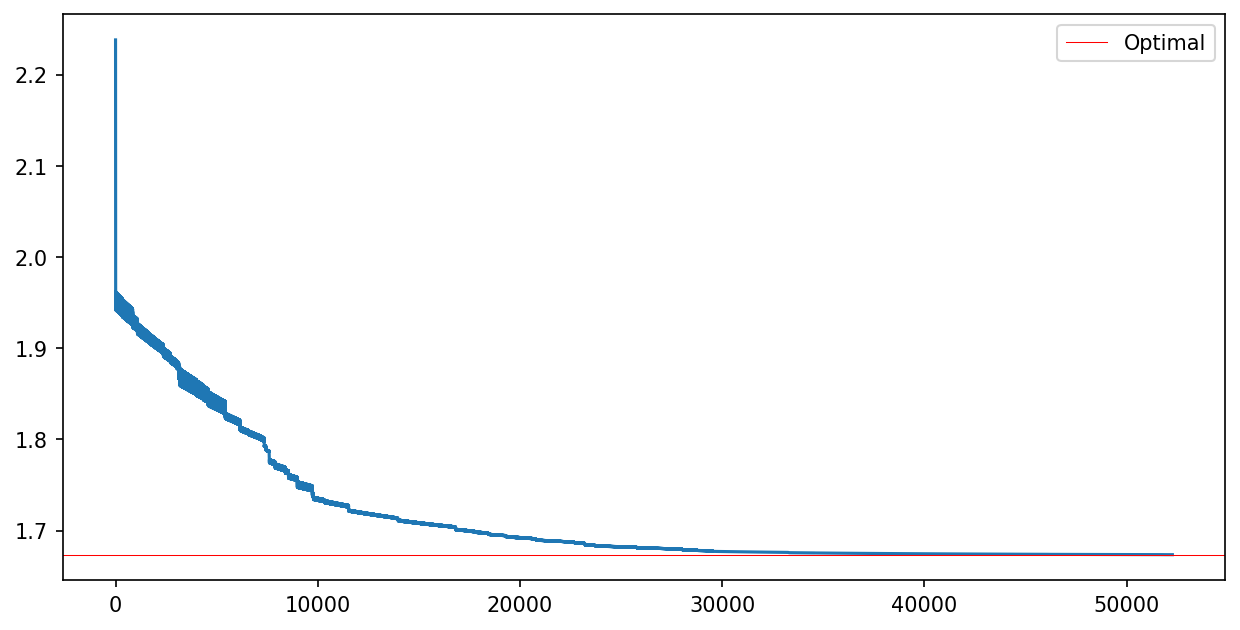

Time elapsed: 14.306749105453491
Epsilon 12: 0.00029763514416313193
0 11.335453932136481
1000 1.9476933673583081
2000 1.9243652603159989
3000 1.9127967502733483
4000 1.898537339473133
5000 1.8847625978834404
6000 1.8696976076869616
7000 1.8601296083852001
8000 1.8478112403494502
9000 1.8275153963611872
10000 1.819815999099662
11000 1.8074788655663157
12000 1.79304158818157
13000 1.7679452541342089
14000 1.7571130225262215
15000 1.7461144686657069
16000 1.7338252137834869
17000 1.7300983171185604
18000 1.7275284463918483
19000 1.7206826275407199
20000 1.7184923188356096
21000 1.7164239164024522
22000 1.7144706499177045
23000 1.71014557423519
24000 1.7084735321231488
25000 1.7068946647104708
26000 1.7054037801207615
27000 1.7039959760495935
28000 1.7000010237752647
29000 1.6979337463812856
30000 1.695720080932654
31000 1.6947120088228886
32000 1.6924643979841
33000 1.6916076644912912
34000 1.6893173939421582
35000 1.6885910828725443
36000 1.6879054974102858
37000 1.6864358727947446
38000

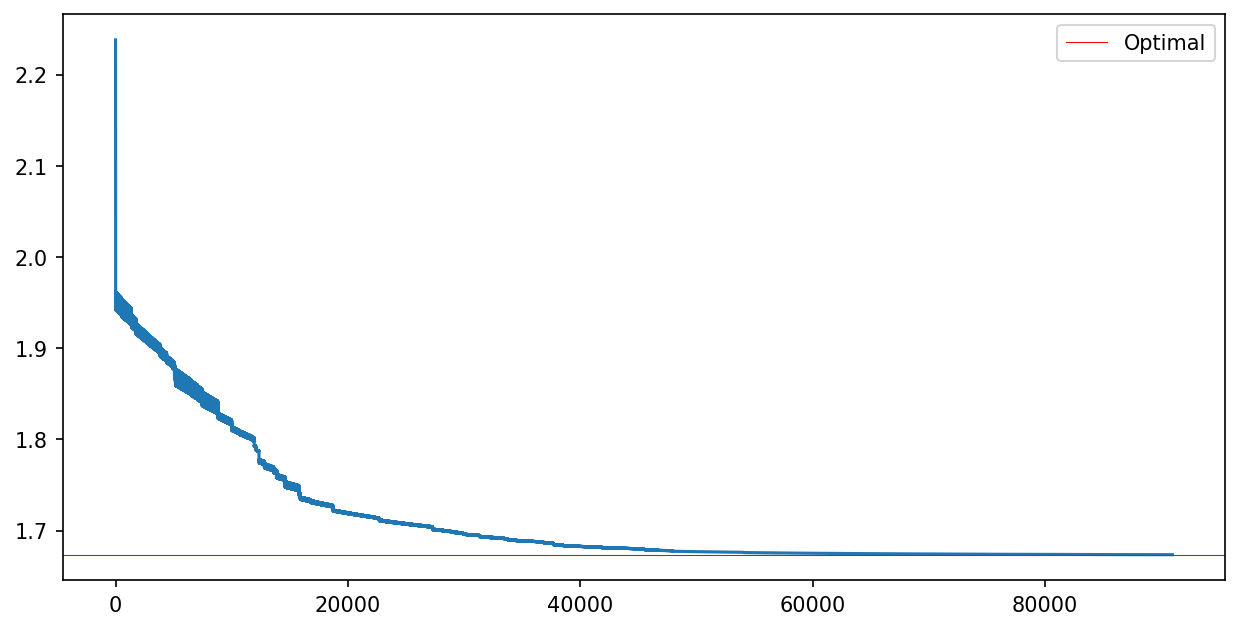

Time elapsed: 30.278327465057373
Epsilon 13: 0.00018329807108324376
0 11.341369805215342
1000 1.9526178322650756
2000 1.9447756410946269
3000 1.9261240103165969
4000 1.9191126159443943
5000 1.9119406014037328
6000 1.9052850988796106
7000 1.8954209946545857
8000 1.885453963476915
9000 1.873822478625303
10000 1.8682934395424522
11000 1.862028322209868
12000 1.8557997787280112
13000 1.8477636171085767
14000 1.8430581985844992
15000 1.8259410475402456
16000 1.821963657702488
17000 1.8109644086957082
18000 1.8069911671356071
19000 1.8035430649309312
20000 1.7875392905156988
21000 1.7682189395174426
22000 1.7657470122784034
23000 1.7565134579939192
24000 1.7468158471613804
25000 1.7448704384458367
26000 1.733791160722385
27000 1.7320838346730465
28000 1.7294582901755151
29000 1.7278804065128224
30000 1.7263568474349944
31000 1.7204773442659984
32000 1.7191207468239331
33000 1.7178111574461947
34000 1.7165469509140923
35000 1.7153265579588566
36000 1.7141484633545527
37000 1.710515341593497
3

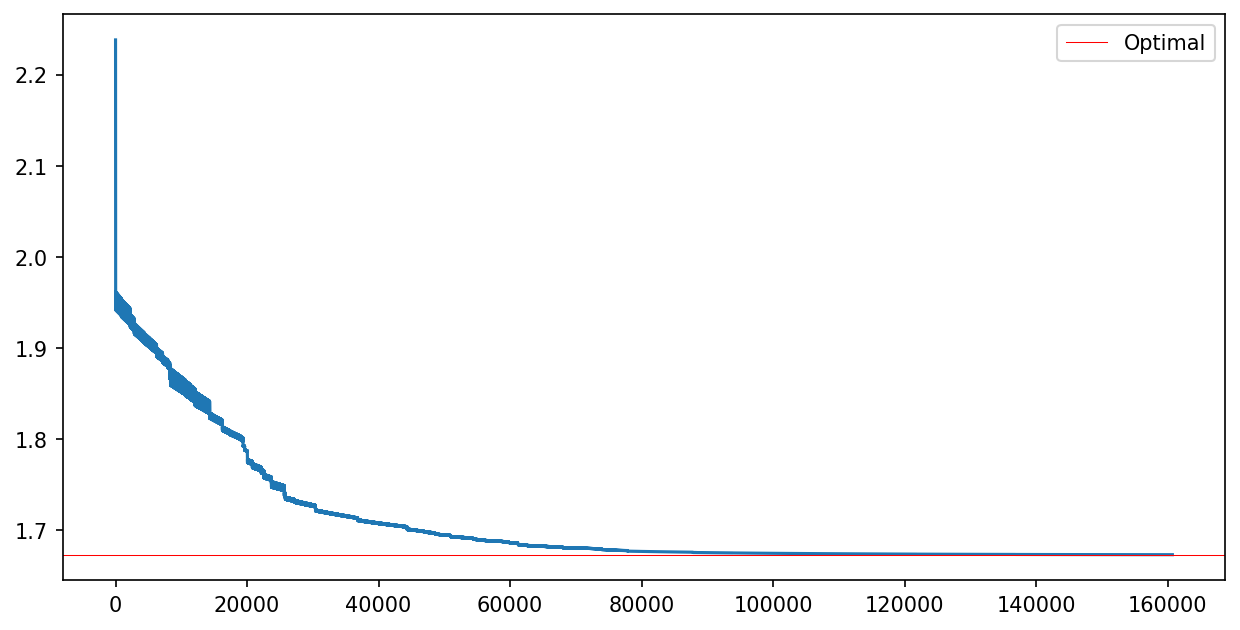

Time elapsed: 53.248518228530884
Epsilon 14: 0.00011288378916846895
0 11.341426166518032
1000 1.956489906444275
2000 1.950774467326815
3000 1.9459520505338217
4000 1.9347919264500497
5000 1.9255584620443642
6000 1.921222793410114
7000 1.9169836882735578
8000 1.9124261969643568
9000 1.9082316980427163
10000 1.9042747389789125
11000 1.896805730445846
12000 1.8899201591329422
13000 1.8854159761459544
14000 1.8759665525047633
15000 1.8724889970837373
16000 1.8690898127849604
17000 1.8657672085273347
18000 1.8615835216718974
19000 1.857304803295486
20000 1.8510792354615624
21000 1.848085645866201
22000 1.8451598530227038
23000 1.8423002927041752
24000 1.8268335932782067
25000 1.8243478018543509
26000 1.8219162589007267
27000 1.812328038416528
28000 1.8100804762289047
29000 1.8074849282315395
30000 1.8053362125532715
31000 1.8027132554553134
32000 1.788425981521142
33000 1.7736167572814927
34000 1.7683728158260033
35000 1.7668370496842583
36000 1.7630634679675934
37000 1.756992344286824
3800

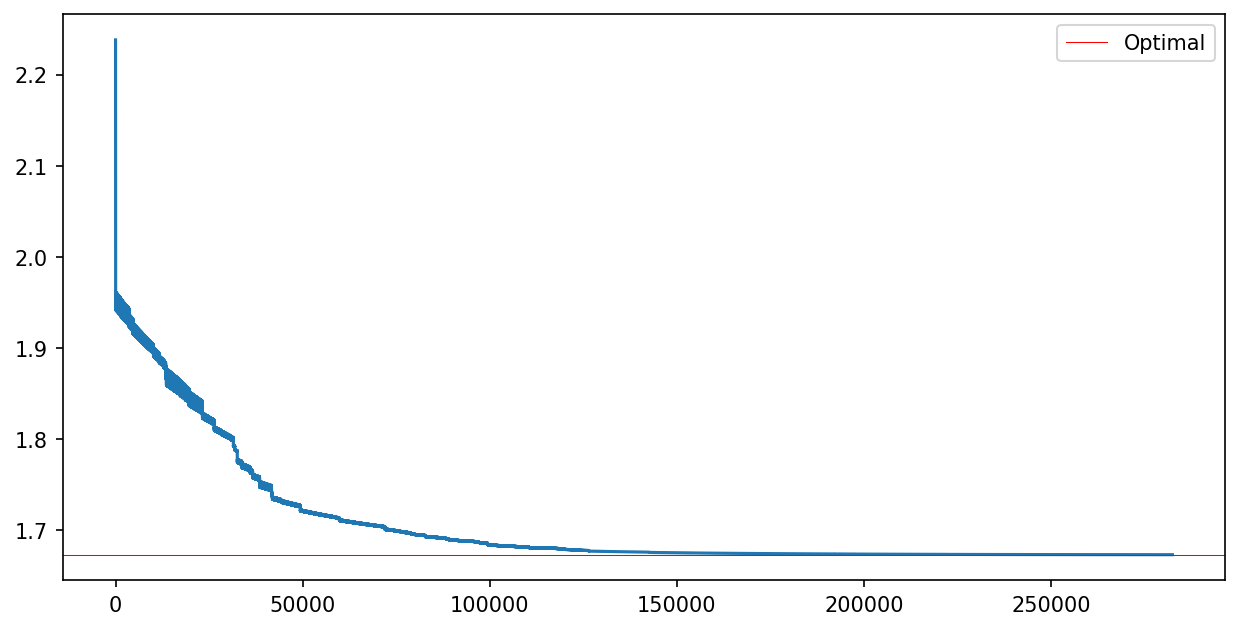

Time elapsed: 96.18821740150452
Epsilon 15: 6.951927961775606e-05
0 11.341426189665679
1000 1.958414831725671
2000 1.9553363257326926
3000 1.95151890435601
4000 1.948525833773876
5000 1.945574159642271
6000 1.9361807937888271
7000 1.933384627853923
8000 1.9258794079888177
9000 1.923193321814092
10000 1.9205442416748337
11000 1.917931652357572
12000 1.9149401718475165
13000 1.912401178509876
14000 1.909750941910918
15000 1.9072825960920274
16000 1.9048482433202205
17000 1.8988316962325307
18000 1.896481977825064
19000 1.8910180669154812
20000 1.8887632875971376
21000 1.8865396293662122
22000 1.8801260942367994
23000 1.875388695358687
24000 1.873245729915053
25000 1.8711326388372023
26000 1.8690489997365902
27000 1.866994396285366
28000 1.8640301561613613
29000 1.86203375727971
30000 1.860068173942306
31000 1.8570200329690703
32000 1.851968731160477
33000 1.850104557675769
34000 1.8482665064843187
35000 1.8464542045926504
36000 1.8446672844605678
37000 1.8429053838691547
38000 1.82834573

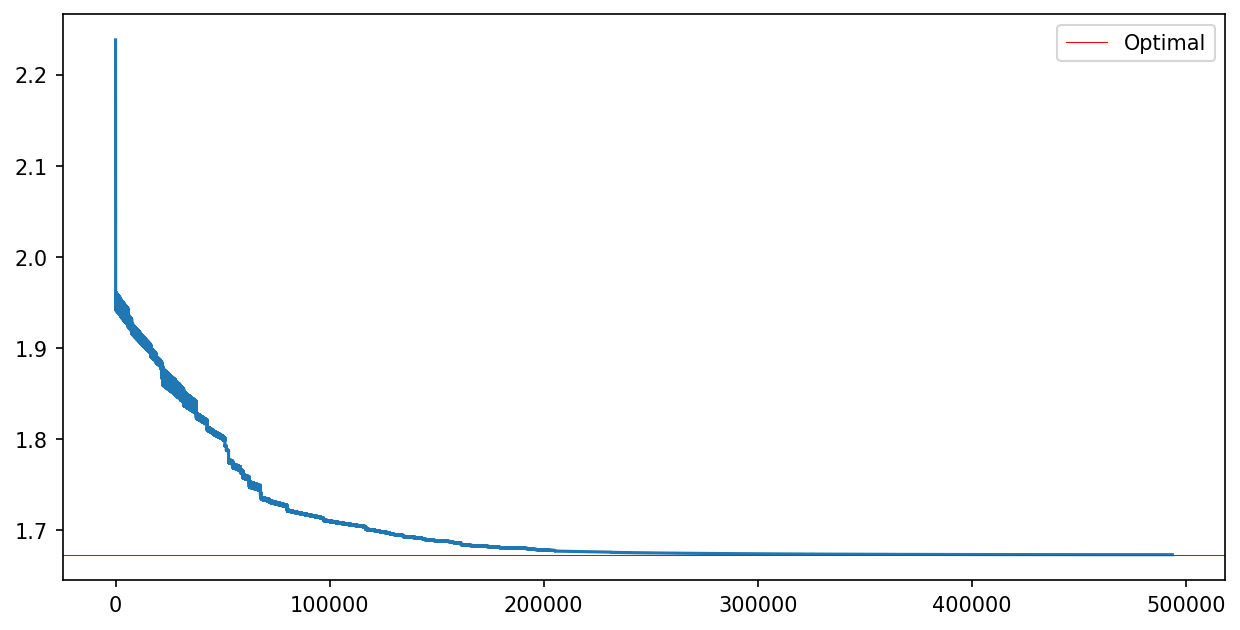

Time elapsed: 135.0349292755127
Epsilon 16: 4.281332398719396e-05
0 11.341426189665729
1000 1.9596086366494094
2000 1.9576974914706486
3000 1.9558026521273482
4000 1.9531420355767732
5000 1.9512799635452818
6000 1.949433795424423
7000 1.9476033947410238
8000 1.9457886261331112
9000 1.9439893554256407
10000 1.9357348407281534
11000 1.9340120337614626
12000 1.9323038439919196
13000 1.9258628978489705
14000 1.9242044082034448
15000 1.922560028294122
16000 1.920929636817308
17000 1.9193131135169275
18000 1.9177103391716586
19000 1.9157056901690734
20000 1.9141313764046475
21000 1.9125704553415264
22000 1.911022811746811
23000 1.9093423049392475
24000 1.907821604074039
25000 1.906313835408944
26000 1.9048188876938348
27000 1.899714181960512
28000 1.8982557081749476
29000 1.896809685542187
30000 1.8953760061514204
31000 1.8908107322672563
32000 1.8894201898978464
33000 1.888041499672524
34000 1.8866745588469804
35000 1.8844362423868262
36000 1.8771889947605536
37000 1.8758501925730868
38000 

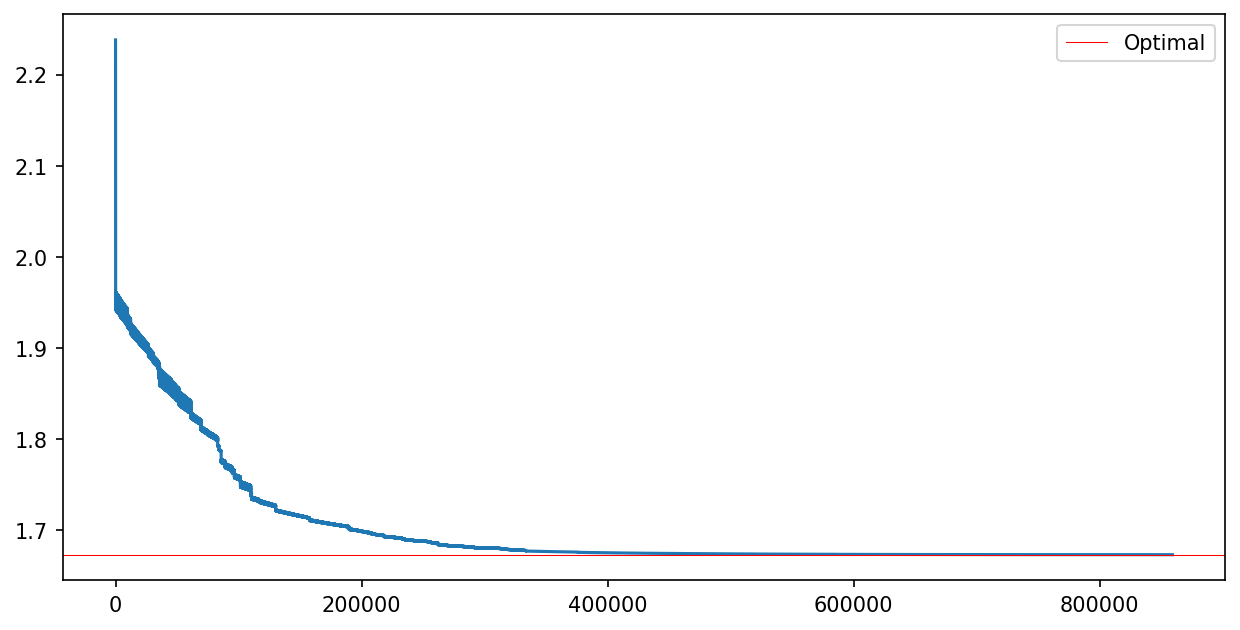

Time elapsed: 231.47774720191956
Epsilon 17: 2.6366508987303607e-05
0 11.341426189665729
1000 1.960347021971268
2000 1.959164222592081
3000 1.957987648510384
4000 1.9568172668049673
5000 1.955653044809631
6000 1.9544949499243953
7000 1.9525611864392074
8000 1.9514156030381502
9000 1.950276055313215
10000 1.949142511264713
11000 1.9480149391476624
12000 1.9468933073301546
13000 1.945777584351078
14000 1.9446677389242943
15000 1.9435637399229355
16000 1.9359882037904481
17000 1.9349241530439283
18000 1.9338656713803337
19000 1.9328127295096031
20000 1.9270037498141084
21000 1.925974707380408
22000 1.9249510658647169
23000 1.9239327966085014
24000 1.9229198711561315
25000 1.9219122611289132
26000 1.9209099383635173
27000 1.9199128747876386
28000 1.918921042537185
29000 1.917934413867047
30000 1.9169529611554503
31000 1.9155612769015453
32000 1.914590904861086
33000 1.9136256251023904
34000 1.9126654106176473
35000 1.911710234514696
36000 1.9107600700629734
37000 1.9096687053874883
38000 1

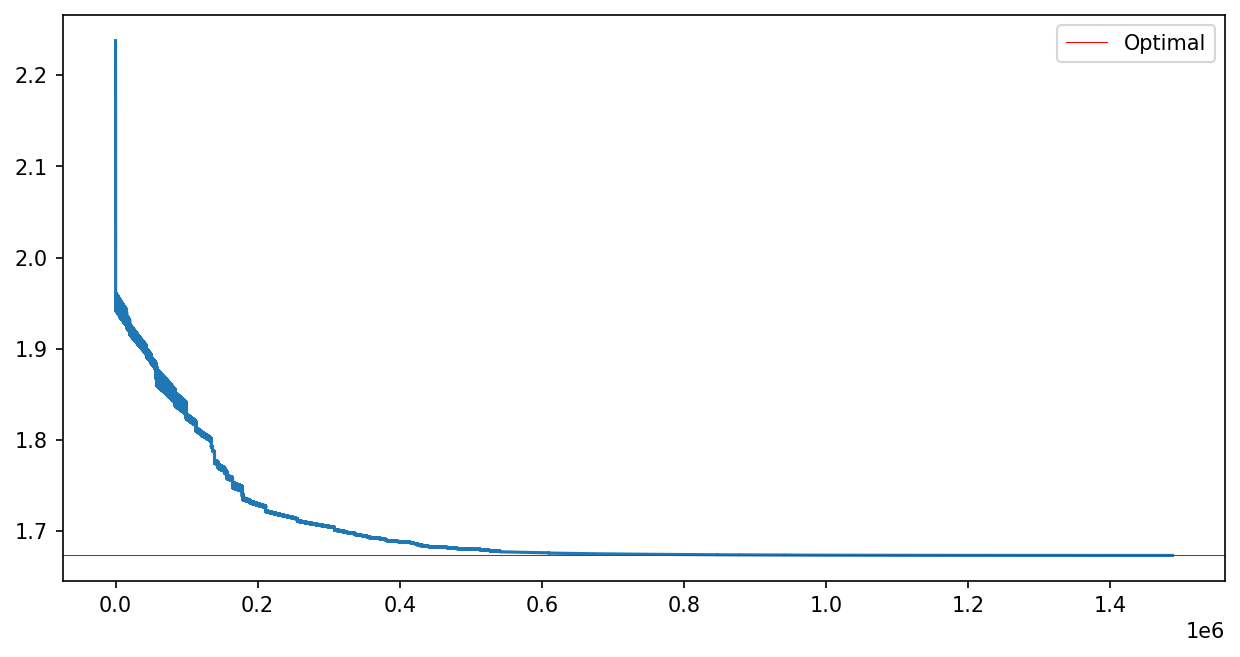

Time elapsed: 412.5126168727875
Epsilon 18: 1.6237767391887242e-05
0 11.341426189665729
1000 1.960802966658481
2000 1.9600723237077462
3000 1.959344051453906
4000 1.9586181421551967
5000 1.9578945881365346
6000 1.957173381683598
7000 1.9564545152209512
8000 1.9557379810582005
9000 1.9550237716425716
10000 1.953529823984507
11000 1.952820456134033
12000 1.9521133923426481
13000 1.951408625119124
14000 1.9507061469519866
15000 1.9500059503825269
16000 1.9493080279572936
17000 1.9486123722515287
18000 1.9479189758678517
19000 1.9472278314590827
20000 1.9465389316391177
21000 1.9458522690914717
22000 1.945167836507801
23000 1.9444856265904076
24000 1.943805632132409
25000 1.9431278458388759
26000 1.9359752589919303
27000 1.9353193462058143
28000 1.934665549735481
29000 1.9340138627429253
30000 1.9333642783695009
31000 1.932716789808292
32000 1.9320713902366105
33000 1.926670706753413
34000 1.9260374095321038
35000 1.9254061614159232
36000 1.9247769556531817
37000 1.924149785539533
38000 1.

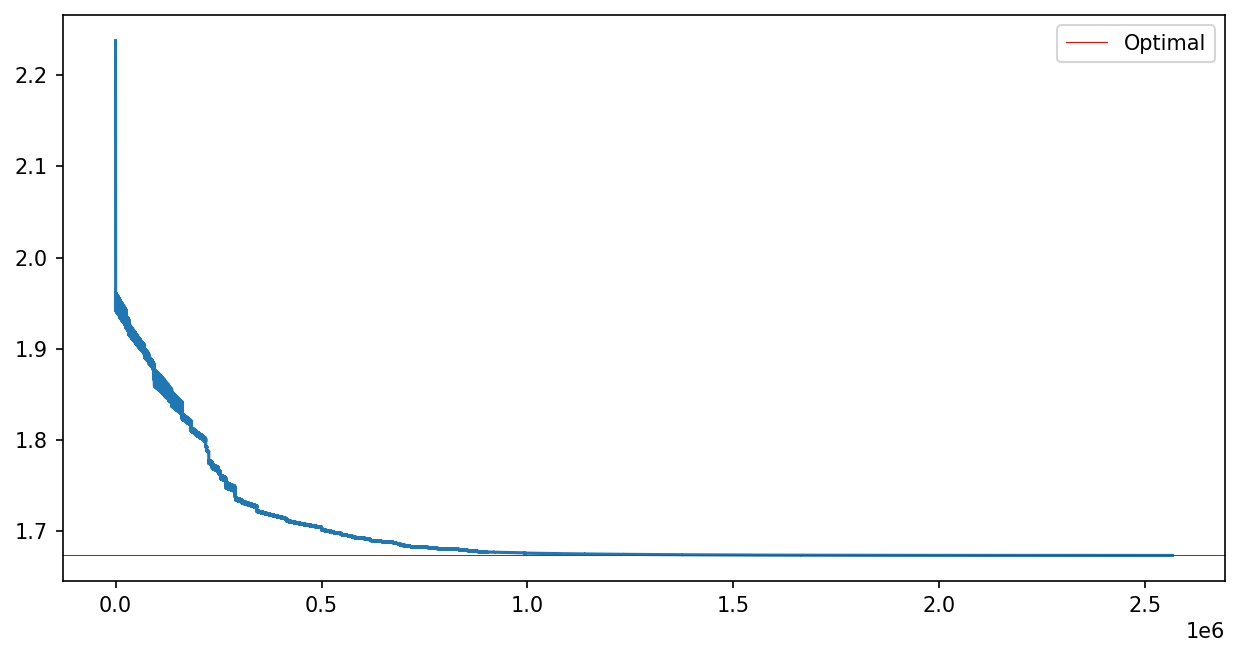

Time elapsed: 663.5350761413574
Epsilon 19: 1e-05
0 11.341426189665729
1000 1.9610842198843879
2000 1.9606334113194976
3000 1.9601835041198785
4000 1.9597344965224068
5000 1.9592863867293084
6000 1.9588391728722159
7000 1.9583928531584374
8000 1.957947425874061
9000 1.957502889165351
10000 1.957059241220213
11000 1.9566164802993815
12000 1.9561746045870252
13000 1.9557336123505125
14000 1.9552935018252429
15000 1.9548542711800487
16000 1.9544159186995884
17000 1.9531964889388862
18000 1.9527600200535722
19000 1.9523244248111866
20000 1.9518897014546563
21000 1.95145584818255
22000 1.9510228632719069
23000 1.9505907449485957
24000 1.95015949152062
25000 1.9497291012402411
26000 1.9492995723510085
27000 1.9488709031352915
28000 1.948443091834101
29000 1.9480161367557034
30000 1.9475900361380227
31000 1.9471647883068781
32000 1.9467403915448118
33000 1.9463168440964087
34000 1.9458941442923072
35000 1.9454722903983814
36000 1.9450512807344404
37000 1.9446311136539367
38000 1.9442117873221

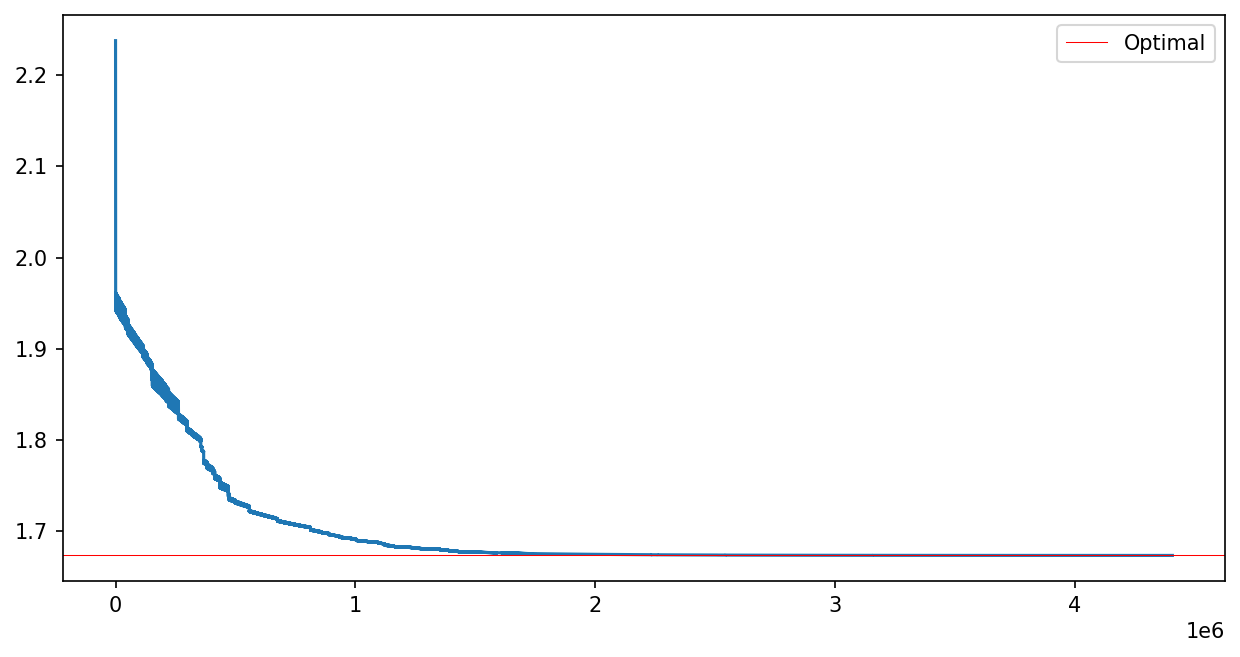

Time elapsed: 1140.248809337616


In [40]:
kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    print(f'Epsilon {i}:', eps)
    start = time.time()

    # Entropic regularization parameter
    U = calc_U(rot, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    erot = rot.entropic_regularize(eta)

    # Sinkhorn
    _, log = robust_sinkhorn_eps(erot, f_hat, eps, 
                                 patience=1000,
                                 save_uv=False, verbose=True)
    
    plt.figure(figsize=(10, 5), dpi=150)
    plt.plot(log['f'][1:])
    plt.axhline(f_hat, color='red', label='Optimal', linewidth=0.5)
    plt.legend()
    plt.show()

    # Find k
    kfs[i] = calc_k_formula(erot, eps)
    kcs[i] = len(log['f']) - 1000

    print('Time elapsed:', time.time() - start)
    print('=================')

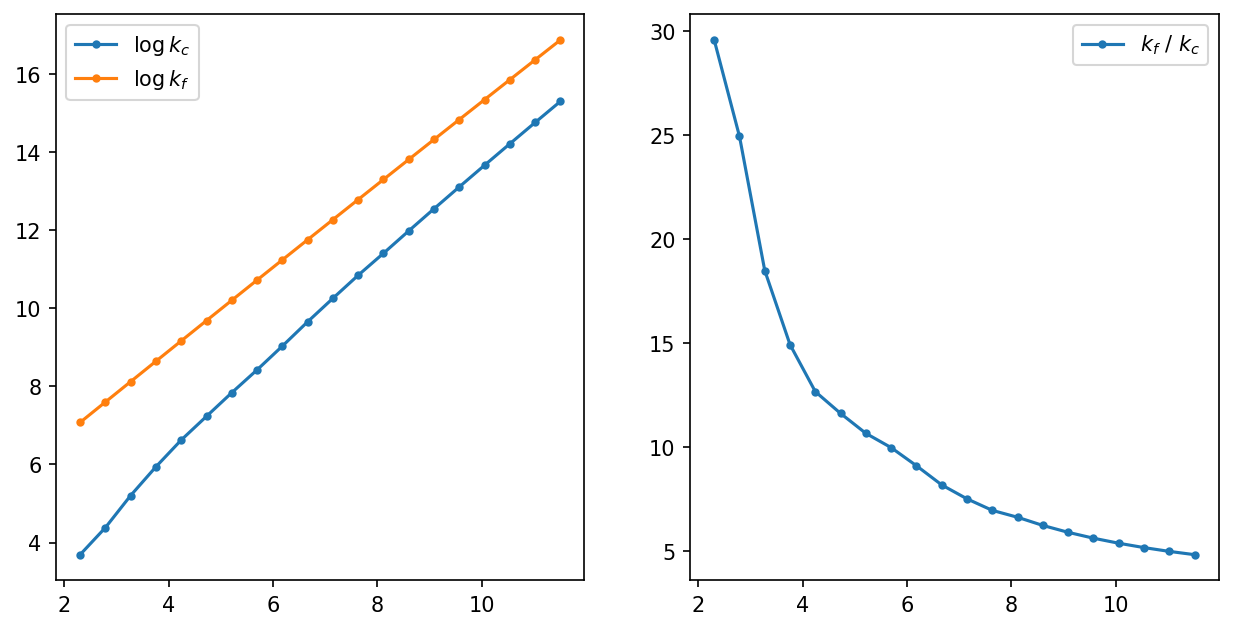

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

ax[0].plot(np.log(1 / eps_arr), np.log(kcs), marker='.', label='$\log k_c$')
ax[0].plot(np.log(1 / eps_arr), np.log(kfs), marker='.', label='$\log k_f$')
ax[0].legend()

ax[1].plot(np.log(1 / eps_arr), kfs / kcs, marker='.', label='$k_f$ / $k_c$')
ax[1].legend()

# Theory checking

Original ROT problem

In [43]:
rot = ROT(C, a, b, tau)

Optimal solution for ROT

In [44]:
X_hat = rot.optimize_f()

f_hat = rot.calc_f(X_hat)

print('Optimal:', f_hat)

Optimal: 1.673249265519985


Entropic ROT problem

In [45]:
# Entropic regularization parameter
eta = np.float64(0.001)

# Convert to Entropic Regularized ROT
erot = rot.entropic_regularize(eta)

Optimal solution for EntropicROT (primal, without normalization constraint)

In [46]:
# Optimal solution for EntropicROT
X_star = erot.optimize_g(with_norm_constraint=True)

f_star = erot.calc_f(X_star)
g_star = erot.calc_g(X_star)

print(X_star.sum())
print('Optimal:', f_star, g_star)

1.0000000060165668
Optimal: 1.6732497400191153 1.667417374384697


Optimal solution for EntropicROT (primal, with normalization constraint)

In [47]:
X_star_hat = erot.optimize_g(with_norm_constraint=False)

f_star_hat = erot.calc_f(X_star_hat)
g_star_hat = erot.calc_g(X_star_hat)

print(X_star_hat.sum())
print('Optimal:', f_star_hat, g_star_hat)

0.43418198480726805
Optimal: 1.13366223399156 1.1307676914695932


$$
    X^* = \dfrac{\bar{X^*}}{||\bar{X^*}||_1}
$$

In [48]:
norm_inf(X_star_hat / X_star_hat.sum(keepdims=True)  - X_star)

6.269657508873455e-09

Optimal solution for Entropic ROT (dual)

In [10]:
# u_star, v_star = erot.optimize_h()
# X_star_dual = erot.calc_B(u_star, v_star)

# f_star_dual = erot.calc_f(X_star_dual)
# g_star_dual = erot.calc_g(X_star_dual)
# h_star_dual = erot.calc_h(u_star, v_star)

# print('Optimal:', f_star_dual, g_star_dual, h_star_dual)

In [49]:
eps = 0.001

# Entropic regularization parameter
U = calc_U(rot, eps)
eta = eps / U

# Convert to Entropic Regularized UOT
erot = rot.entropic_regularize(eta)

In [50]:
start = time.time()

# Sinkhorn
_, log = robust_sinkhorn_eps(erot, f_hat, eps, 
                             save_uv=True,
                             patience=1000, verbose=True)

print('Time elapsed:', time.time() - start)

0 10.614799971141117
1000 1.9088053535144354
2000 1.8624984780415483
3000 1.8133108669571576
4000 1.766181298169512
5000 1.730633220123768
6000 1.7181562156506631
7000 1.7092663993413153
8000 1.7041629910456222
9000 1.6954747764650504
10000 1.690597408512276
11000 1.6865165233890076
12000 1.682545836046732
13000 1.680597460508783
14000 1.6782017430165275
15000 1.6767789585098172
16000 1.6761903542692598
17000 1.6754120546550348
18000 1.6750391967935336
19000 1.6747318407073735
20000 1.674478479964522
21000 1.674269630064624
22000 1.6740886492785907
22139 1.6740721332993114
Time elapsed: 6.4185895919799805


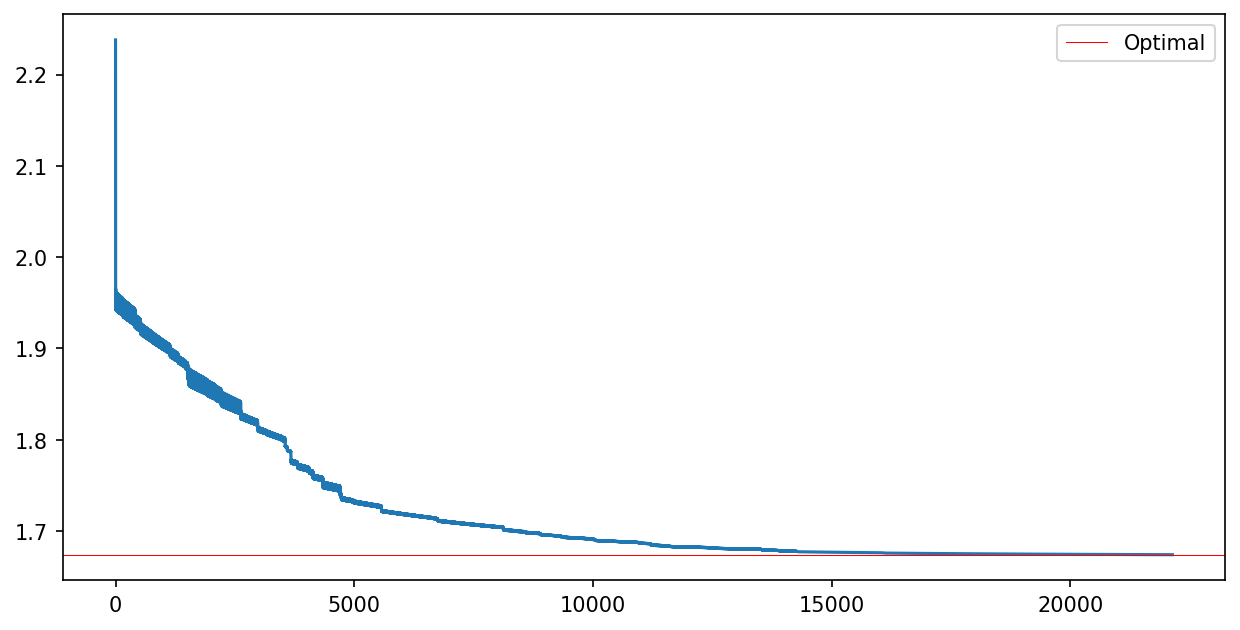

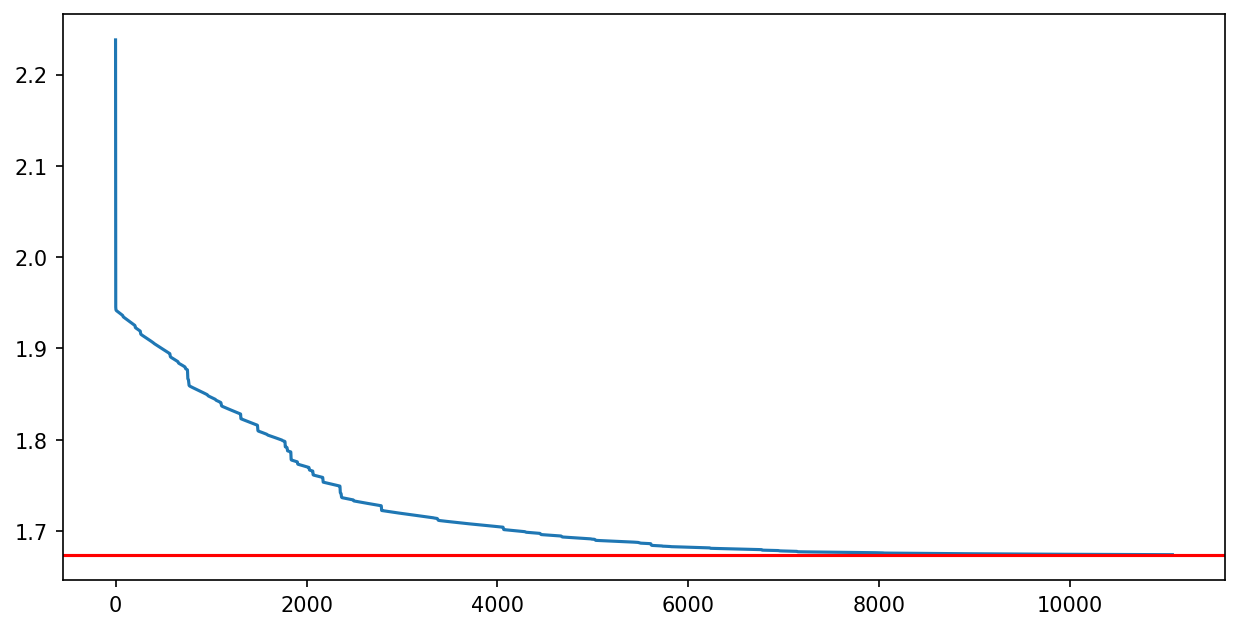

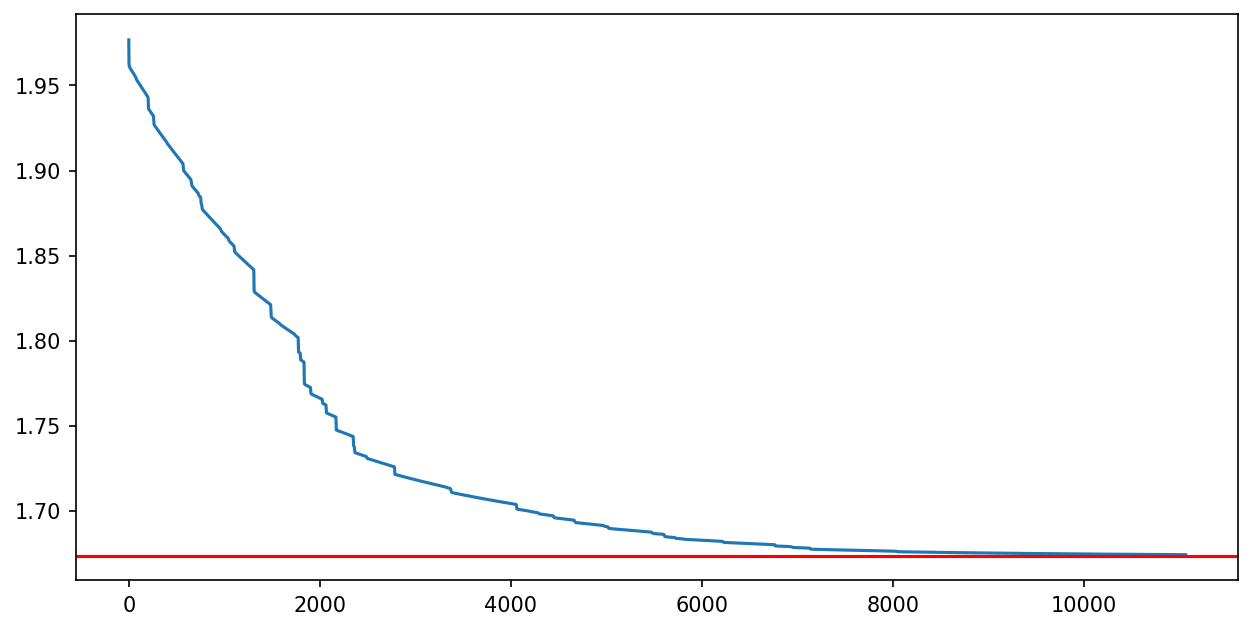

In [51]:
# Overview
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(log['f'][1:])
plt.axhline(f_hat, color='red', label='Optimal', linewidth=0.5)
plt.legend()
plt.show()

# After u update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(log['f'][1::2])
plt.axhline(f_hat, color='red')
plt.show()

# After v update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(log['f'][2::2])
plt.axhline(f_hat, color='red')
plt.show()

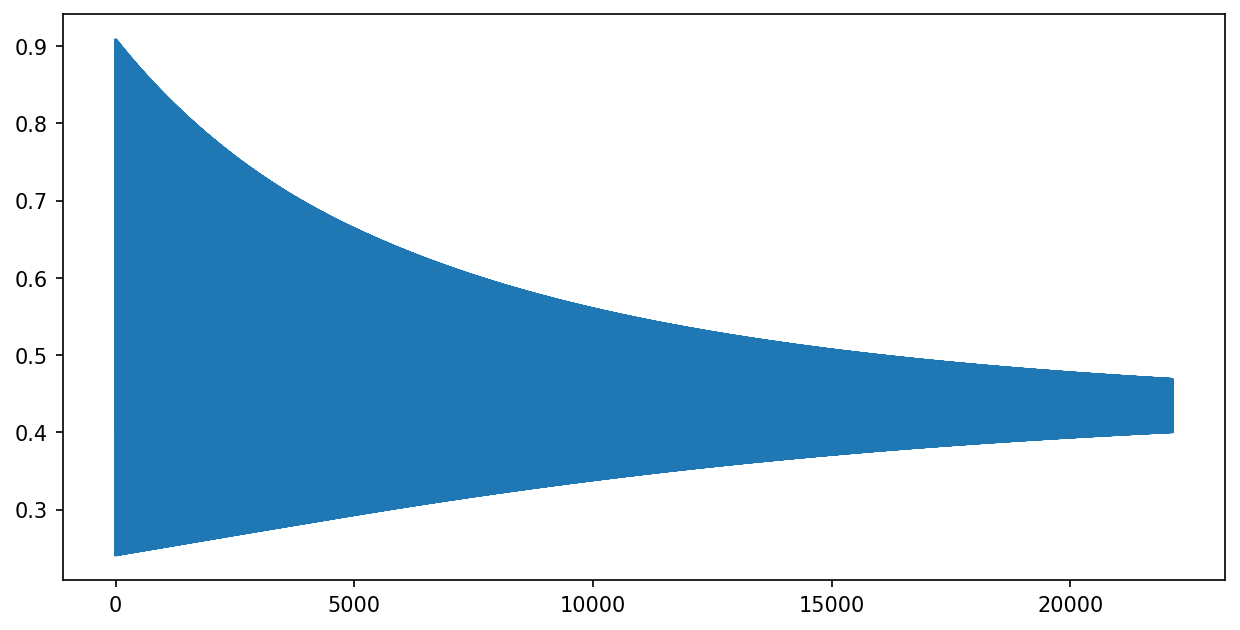

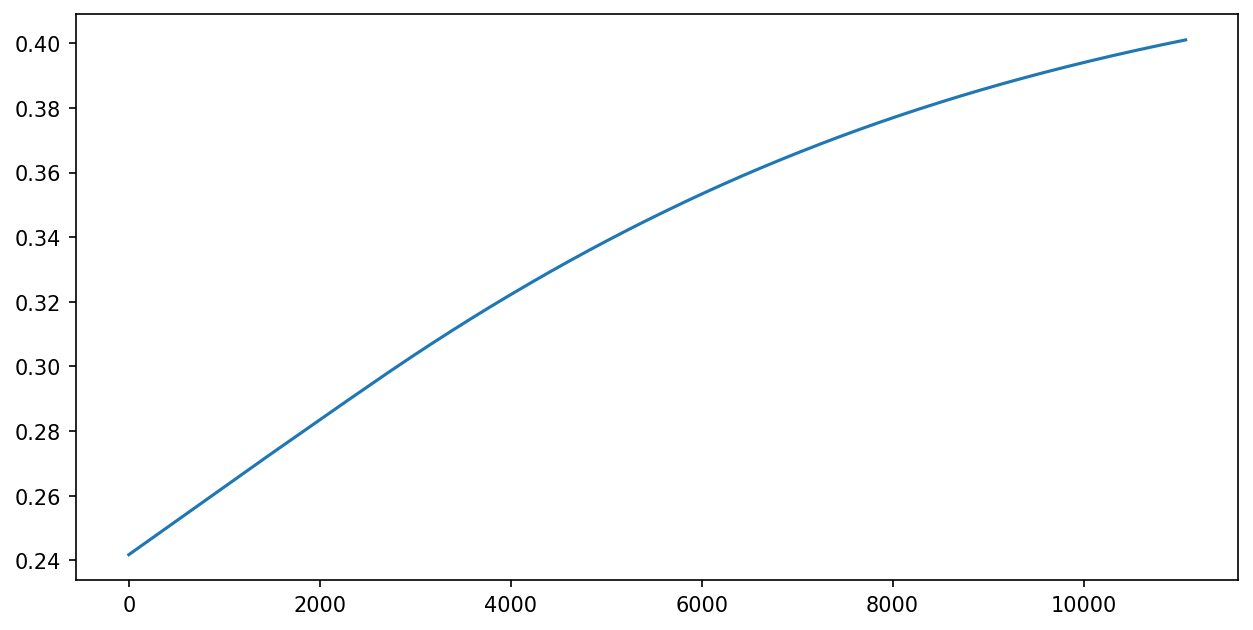

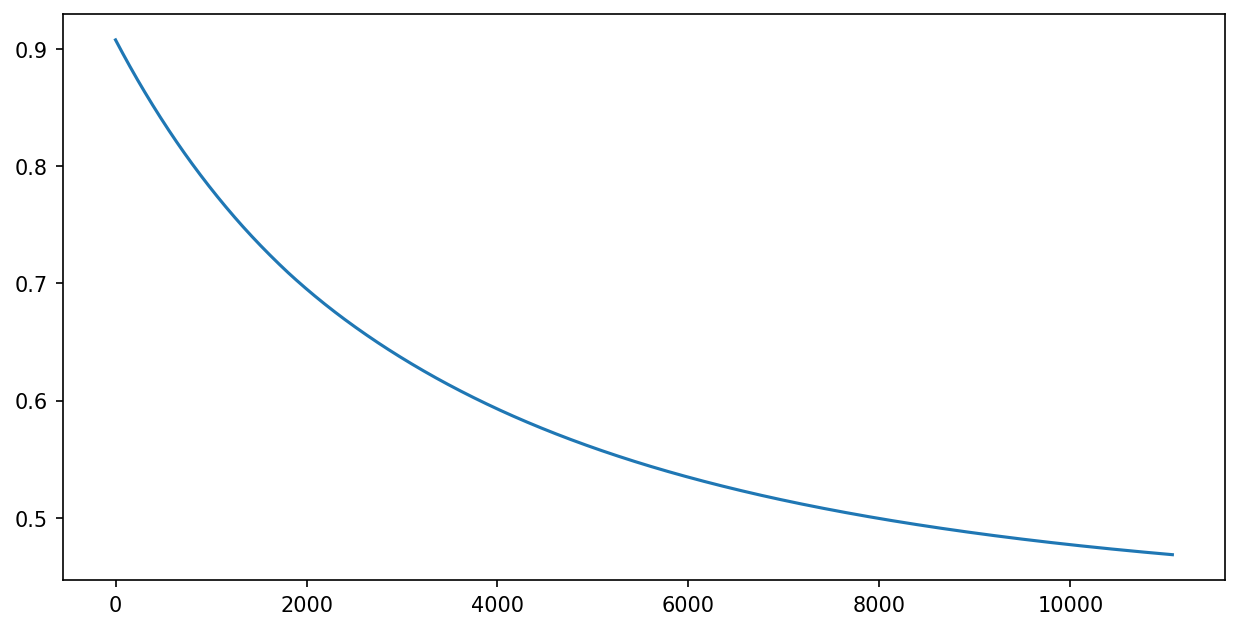

In [52]:
y = []

for uk, vk in zip(log['u'], log['v']):
    Xk = erot.calc_B(uk, vk)
    
    y.append(Xk.sum())

# Overview
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[1::])
# plt.axhline(g_star, color='red', label='Optimal', linewidth=0.5)
# plt.legend()
plt.show()

# Each u update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[1::2])
# plt.axhline(g_star, color='red')
plt.show()

# Each v update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[2::2])
# plt.axhline(g_star, color='red')
plt.show()

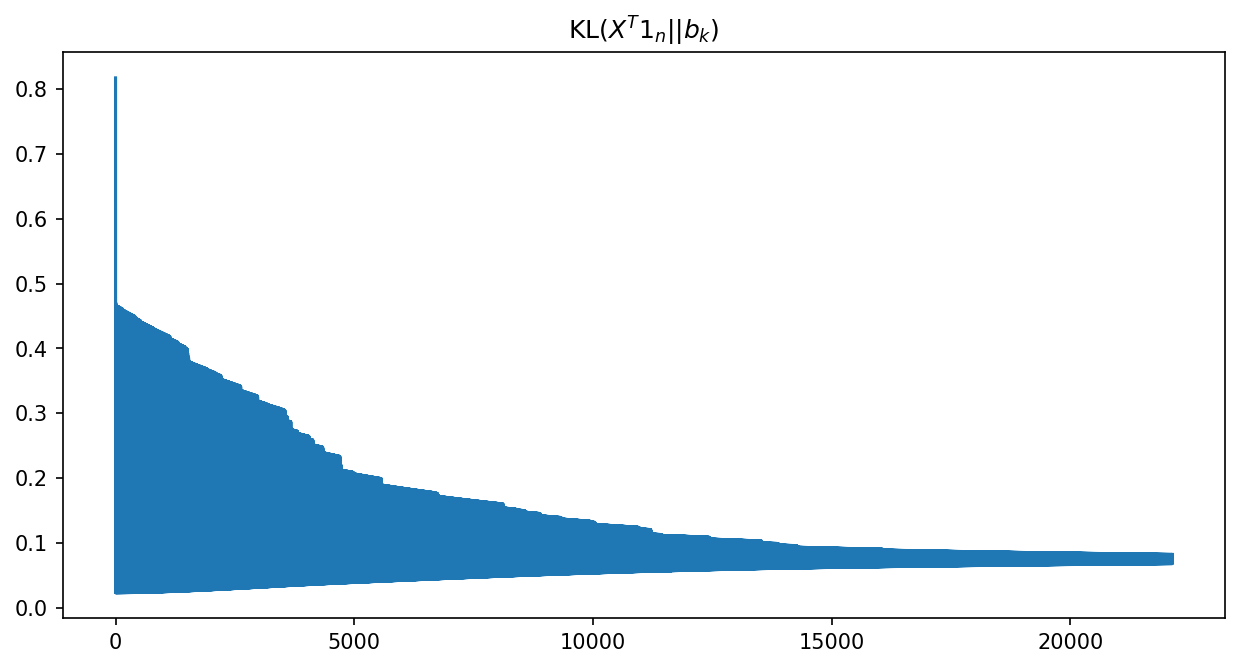

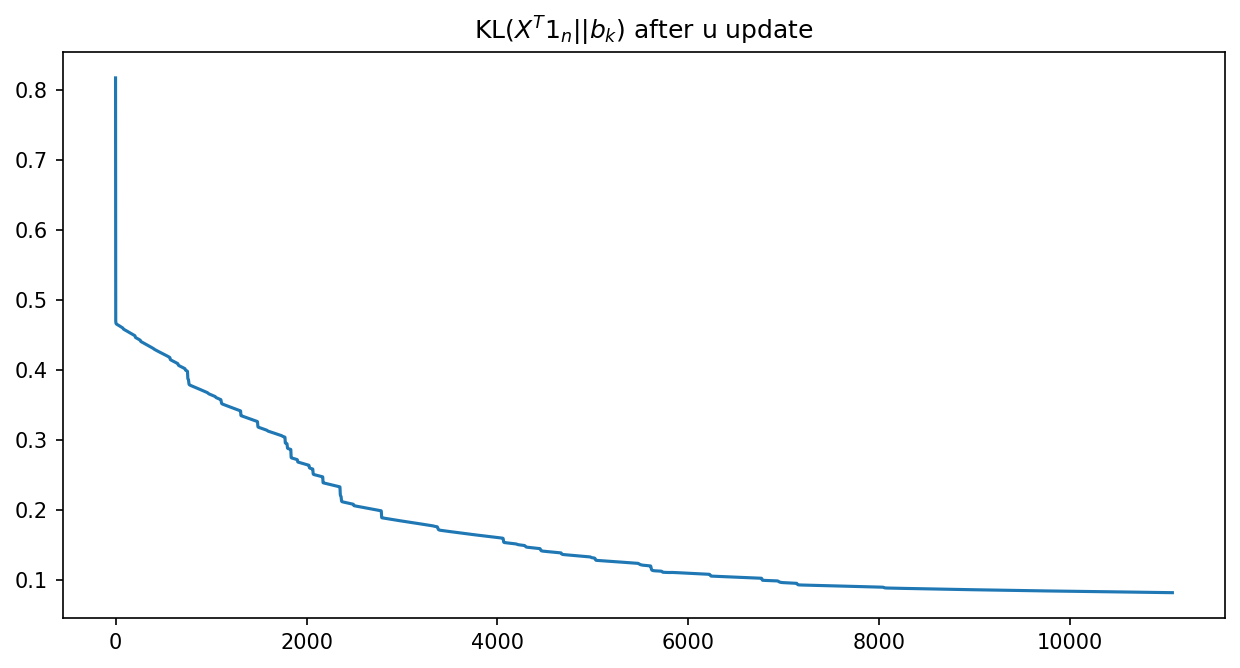

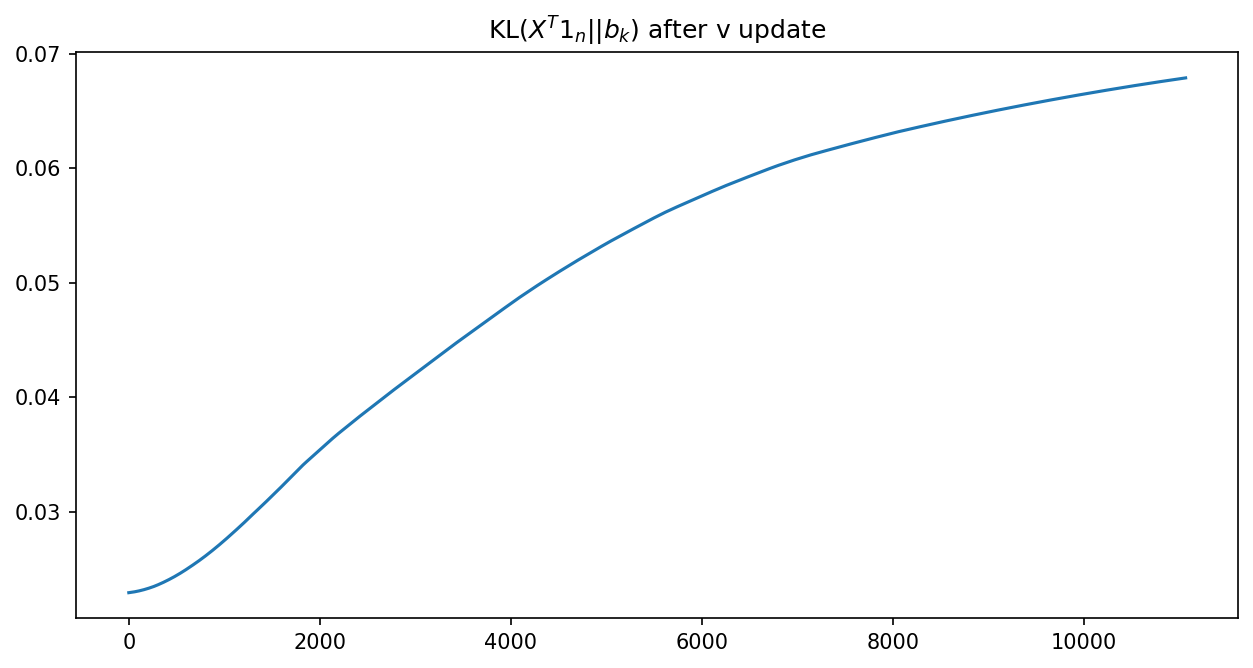

In [53]:
y = []

for uk, vk in zip(log['u'], log['v']):
    Xk = erot.calc_logB(uk, vk)
    Xk = np.exp(Xk - logsumexp(Xk))

    bk = Xk.sum(0)

    y.append(calc_KL(bk, erot.b))

# Overview
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[1:])
plt.title('KL$(X^T 1_n || b_k)$')
plt.show()

# Each u update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[1::2])
plt.title('KL$(X^T 1_n || b_k)$ after u update')
plt.show()

# Each v update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[2::2])
plt.title('KL$(X^T 1_n || b_k)$ after v update')
plt.show()

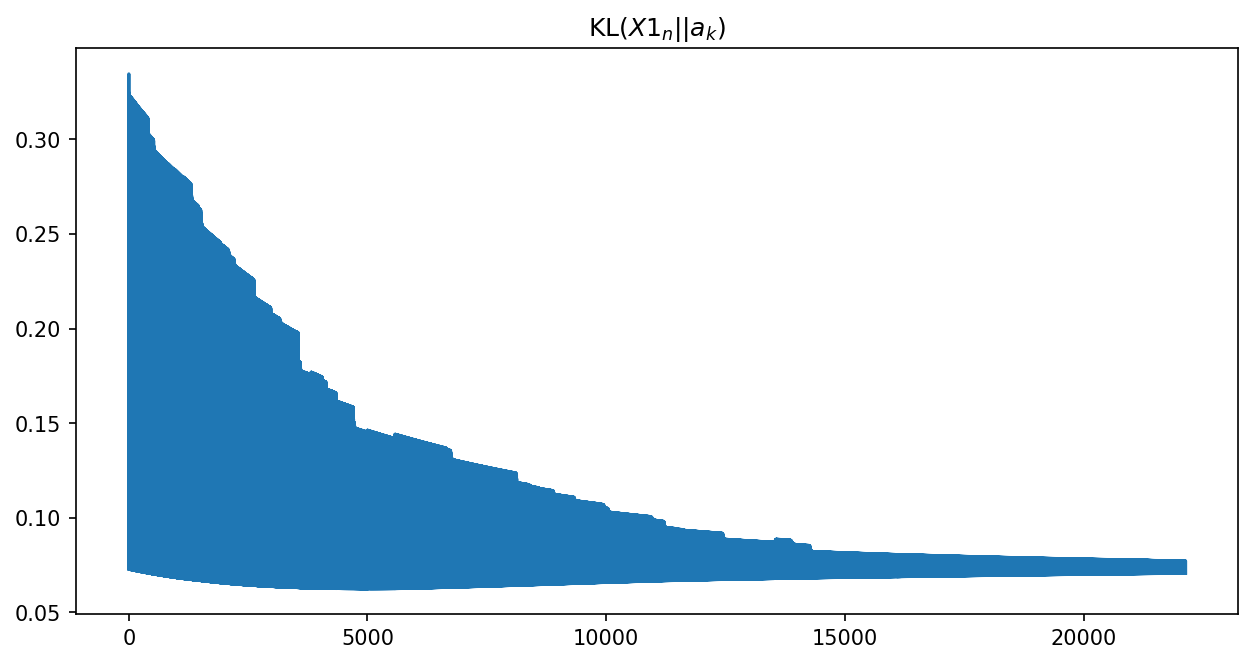

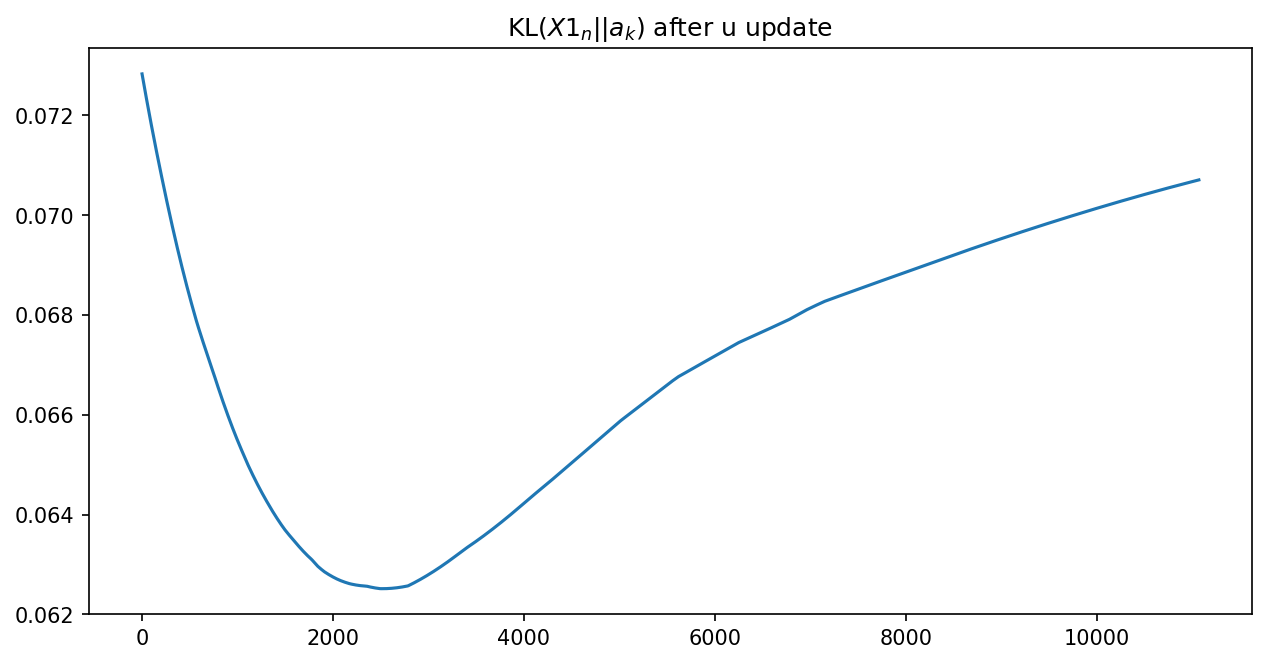

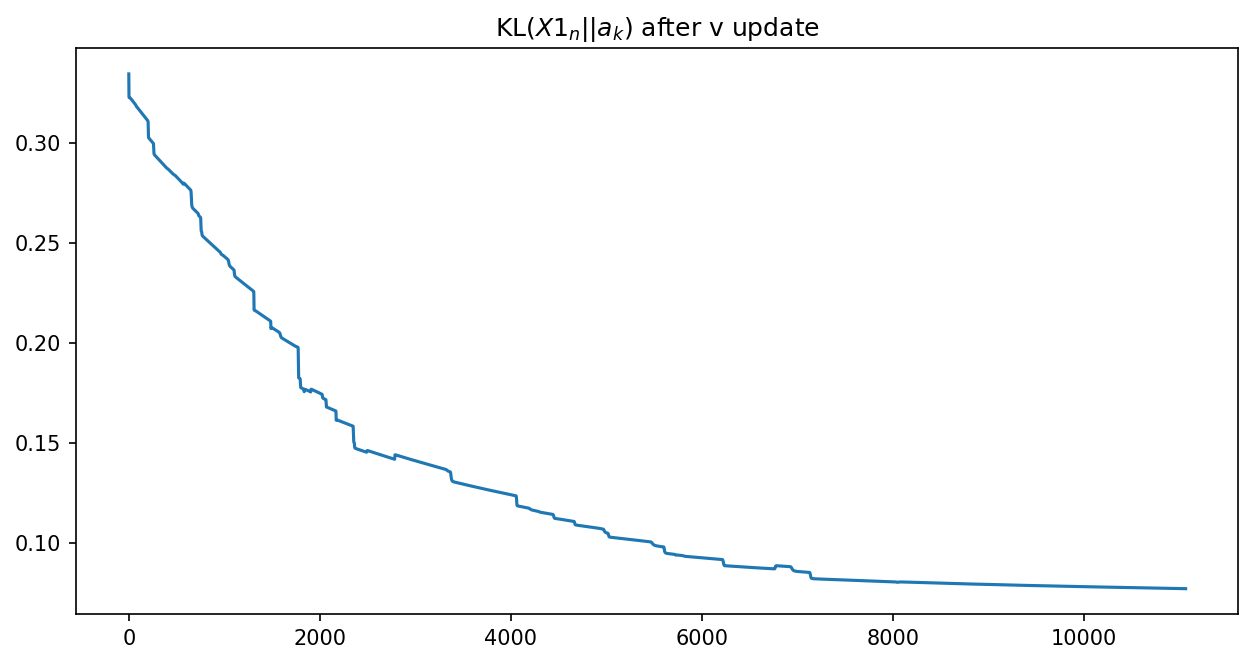

In [54]:
y = []

for uk, vk in zip(log['u'], log['v']):
    Xk = erot.calc_logB(uk, vk)
    Xk = np.exp(Xk - logsumexp(Xk))

    ak = Xk.sum(-1)

    y.append(calc_KL(ak, erot.a))

# Overview
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[1:])
plt.title('KL$(X 1_n || a_k)$')
plt.show()

# Each u update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[1::2])
plt.title('KL$(X 1_n || a_k)$ after u update')
plt.show()

# Each v update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(y[2::2])
plt.title('KL$(X 1_n || a_k)$ after v update')
plt.show()